In [19]:
import os
import random
from datetime import datetime
import numpy as np
import requests

from PIL import Image

from imgbeddings import imgbeddings
import umap
import umap.plot

In [20]:
files_to_remove = ['.DS_Store']
batch_size = 64

root_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_folder = '0_data/beanleaf_dataset'
beandataset_folder = os.path.join(root_folder, data_folder)
beanleaf_data_partition_folders = os.listdir(beandataset_folder)
beanleaf_data_partition_folders = [i for i in beanleaf_data_partition_folders if i not in files_to_remove]

## Get files from each folder (test, train & validation)

In [21]:
def run_scandir_by_extn(dir, ext):
    subfolders, files = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if os.path.splitext(f.name)[1].lower() in ext:
                files.append(f.path)

    for dir in list(subfolders):
        sf, f = run_scandir_by_extn(dir, ext)
        subfolders.extend(sf)
        files.extend(f)
    return subfolders, files

def run_scandir_with_exclusion(dir, exclude):
    subfolders, files = [], []

    for f in os.scandir(dir):
        if f.is_dir():
            subfolders.append(f.path)
        if f.is_file():
            if f.name not in exclude:
                files.append(f.path)

    for dir in list(subfolders):
        sf, f = run_scandir_with_exclusion(dir, exclude)
        subfolders.extend(sf)
        files.extend(f)
    return subfolders, files

In [22]:
ibed = imgbeddings()

#column headers for the csv
header = ['name', 'url', 'actual_label', 'predicted_label', 'prediction_ts', 'vector']

/Users/jaganlalthoppe/workspace/mlops/azure/beanleaf-disease-classifier/env/lib/python3.9/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


### Create embeddings for test dataset

In [23]:
embeddings_folder = '0_data/embeddings'
embeddings_folder_path = os.path.join(root_folder, embeddings_folder)

In [24]:
class_dict = {
    'angular_leaf_spot': 0,
    'bean_rust': 1,
    'healthy': 2
}

embeddings_for_all_images = []
labels_for_all_images = []

def write_to_csv(files, writer, actual_label, predicted_label, prediction_ts, random_prediction=False):
    file_count = len(files)
    chunks = (file_count - 1)
    # actual_label = class_dict[actual_label]
    # predicted_label = class_dict[predicted_label]
    classes = ['angular_leaf_spot', 'bean_rust', 'healthy']
    for i in range(chunks):
        embeddings = []
        batch_files = files[i*batch_size:(i+1)*batch_size]
        if len(batch_files):
            embeddings = ibed.to_embeddings(batch_files)
            # Iterate directory
            for index in range(len(batch_files)):
                data = []
                data.append(os.path.basename(batch_files[index]))
                data.append(batch_files[index])
                data.append(actual_label)

                if random_prediction:
                    predicted_label = random.choice(classes)

                data.append(predicted_label)
                data.append(prediction_ts)
                data.append(embeddings[index])

                embeddings_for_all_images.append(embeddings[index])
                labels_for_all_images.append(predicted_label)

                # write the data
                writer.writerow(data)

def create_embeddings_and_append(files, label):
    file_count = len(files)
    chunks = (file_count - 1)
    for i in range(chunks):
        embeddings = []
        batch_files = files[i*batch_size:(i+1)*batch_size]
        if len(batch_files):
            embeddings = ibed.to_embeddings(batch_files)
            # Iterate directory
            for index in range(len(batch_files)):
                embeddings_for_all_images.append(embeddings[index])
                labels_for_all_images.append(label)

### Create embeddings for train dataset

In [25]:
now_ts = datetime.timestamp(datetime.now())

In [26]:
train_file_path = os.path.join(embeddings_folder_path, 'beanleaf_train.csv')

train_dataset_folder = os.path.join(beandataset_folder, beanleaf_data_partition_folders[1])
train_dataset_classes_folder = os.listdir(train_dataset_folder)
train_dataset_classes_folder = [i for i in train_dataset_classes_folder if i not in files_to_remove]

for train_class in train_dataset_classes_folder:
    fullpath_with_class = os.path.join(train_dataset_folder, train_class)
    train_subfolders, train_files = run_scandir_with_exclusion(fullpath_with_class, files_to_remove)
    print(train_class)
    create_embeddings_and_append(train_files, train_class)

healthy


100%|██████████| 64/64 [00:01<00:00, 32.37it/s]


angular_leaf_spot


100%|██████████| 64/64 [00:01<00:00, 35.45it/s]


bean_rust


100%|██████████| 64/64 [00:01<00:00, 34.06it/s]


### Create embeddings for validation dataset

In [27]:

validation_file_path = os.path.join(embeddings_folder_path, 'beanleaf_validation.csv')

validation_dataset_folder = os.path.join(beandataset_folder, beanleaf_data_partition_folders[2])
validation_dataset_classes_folder = os.listdir(validation_dataset_folder)
validation_dataset_classes_folder = [i for i in validation_dataset_classes_folder if i not in files_to_remove]

for validation_class in validation_dataset_classes_folder:
    fullpath_with_class = os.path.join(validation_dataset_folder, validation_class)
    validation_subfolders, validation_files = run_scandir_with_exclusion(fullpath_with_class, files_to_remove)

    print(validation_class)
    create_embeddings_and_append(validation_files, validation_class)

healthy
angular_leaf_spot
bean_rust


### Create embeddings for test dataset (consider as production dataset)

In [28]:
now_ts = datetime.timestamp(datetime.now())

In [29]:
test_file_path = os.path.join(embeddings_folder_path, 'beanleaf_test.csv')

test_dataset_folder = os.path.join(beandataset_folder, beanleaf_data_partition_folders[0])
test_dataset_classes_folder = os.listdir(test_dataset_folder)
test_dataset_classes_folder = [i for i in test_dataset_classes_folder if i not in files_to_remove]

now_ts = datetime.timestamp(datetime.now())
for test_class in test_dataset_classes_folder:
    fullpath_with_class = os.path.join(test_dataset_folder, test_class)
    test_subfolders, test_files = run_scandir_with_exclusion(fullpath_with_class, files_to_remove)
    print(test_class)
    create_embeddings_and_append(test_files, test_class)

healthy
angular_leaf_spot
bean_rust


#### UMAP unsupervised clustering
umap is a tool that can cluster embeddings (better/more efficient than the popular tSNE) and then visualize the results.
Using cosine similarity works best here.

In [30]:
catdog_folder = os.path.join(root_folder, '0_data', 'catsanddogs')
print(catdog_folder)

catdog_dataset_classes_folder = os.listdir(catdog_folder)
catdog_dataset_classes_folder = [i for i in catdog_dataset_classes_folder if i not in files_to_remove]

for animal_class in catdog_dataset_classes_folder:
    fullpath_with_class = os.path.join(catdog_folder, animal_class)
    train_subfolders, animals_files = run_scandir_with_exclusion(fullpath_with_class, files_to_remove)
    create_embeddings_and_append(animals_files, 'animal')

/Users/jaganlalthoppe/workspace/mlops/azure/beanleaf-disease-classifier/0_data/catsanddogs


100%|██████████| 64/64 [00:01<00:00, 37.55it/s]


In [35]:
umap_beanleaf = umap.UMAP(
    n_neighbors=4, n_components=2, metric="cosine"
).fit(embeddings_for_all_images)

<AxesSubplot:>

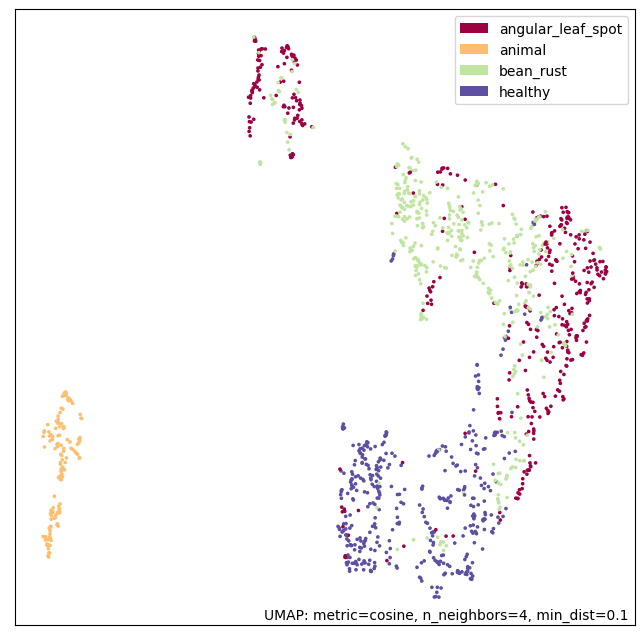

In [36]:
umap.plot.points(umap_beanleaf, labels=np.array(labels_for_all_images))